# VQE on Aer simulator with noise

This notebook demonstrates using the [Qiskit Aer](https://qiskit.org/documentation/the_elements.html#aer) `aer_simulator` to run a simulation with noise, based on a given noise model. This can be useful to investigate behavior under different noise conditions. Aer not only allows you to define your own custom noise model, but also allows a noise model to be easily created based on the properties of a real quantum device. The latter is what this notebook will demonstrate since the goal is to show VQE with noise and not the more complex task of how to build custom noise models.

[Qiskit Ignis](https://qiskit.org/documentation/apidoc/ignis.html) provides a solution to mitigate the measurement error when running on a noisy simulation or a real quantum device. This solution is leveraged by the `QuantumInstance` module which allows any algorithm using it to automatically have measurement noise mitigation applied.

Further information on Qiskit Aer noise model can be found in the online [Qiskit Aer documentation](https://qiskit.org/documentation/apidoc/aer_noise.html), also there is tutorial for [building noise models](../simulators/3_building_noise_models.ipynb).

Further information on  measurement error mitigation in Qiskit Ignis can be found in the tutorial for [measurement error mitigation](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html).

In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

Noisy simulation will be demonstrated here with VQE, finding the minimum (ground state) energy of an Hamiltonian, but the technique applies to any quantum algorithm from Qiskit.

So for VQE we need a qubit operator as input. Here, once again, we will take a set of paulis that were originally computed by Qiskit Nature, for an H2 molecule, so we can quickly create an Operator.

In [2]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


As the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value so we can compare later the results. 

In [3]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


## Performance *without* noise

First we will run on the simulator without adding noise to see the result. I have created the backend and QuantumInstance, which holds the backend as well as various other run time configuration, which are defaulted here, so it easy to compare when we get to the next section where noise is added. There is no attempt to mitigate noise or anything in this notebook so the latter setup and running of VQE is identical.

In [4]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.84722
Delta from reference energy value is 0.01005


We captured the energy values above during the convergence so we can see what went on in the graph below.

Text(0.5, 1.0, 'Convergence with no noise')

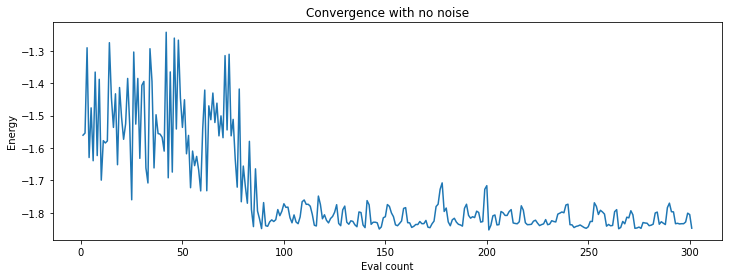

In [5]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

## Performance *with* noise

Now we will add noise. Here we will create a noise model for Aer from an actual device. You can create custom noise models with Aer but that goes beyond the scope of this notebook. Links to further information on Aer noise model, for those that may be interested in doing this, were given above.

First we need to get an actual device backend and from its `configuration` and `properties` we can setup a coupling map and a noise model to match the device. While we could leave the simulator with the default all to all map, this shows how to set the coupling map too. Note: We can also use this coupling map as the entanglement map for the variational form if we choose.

Note: simulation with noise will take longer than without noise.

Terra Mock Backends:

We will use real noise data for an IBM Quantum device using the date stored in Qiskit Terra. Specifically, in this tutorial, the device is ibmq_vigo.

In [6]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['sx', 'measure', 'id', 'cx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]

VQE on Aer qasm simulator (with noise): -1.78243
Delta from reference energy value is 0.07484

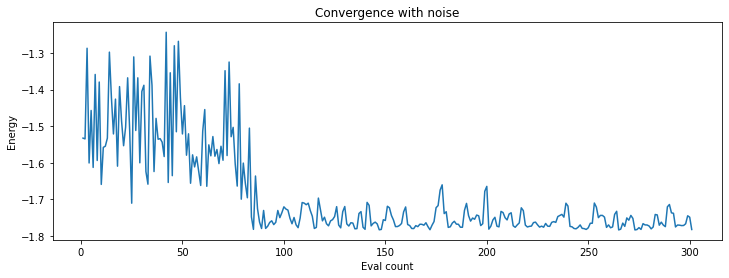

In [7]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

## Performance *with* noise and measurement error mitigation

Now we will add method for measurement error mitigation, which increases the fidelity of measurement. Here we choose `CompleteMeasFitter` to mitigate the measurement error. The calibration matrix will be auto-refresh every 30 minute (default value).

Note: simulation with noise will take longer than without noise.

In [8]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.83430
Delta from reference energy value is 0.02298


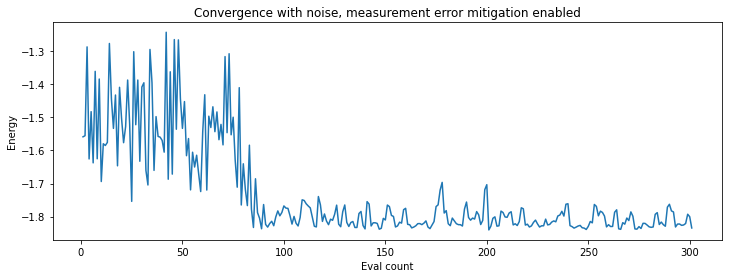

In [9]:
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled')

Lets bring the results together here for a summary. 

We produced a reference value using a classical algorithm and then proceeded to run VQE on a qasm simulator. While the simulation is ideal (no noise) there is so called shot-noise due to sampling - increasing the number of shots reduces this as more and more samples are taken, but shots was left at the default of 1024 and we see a small effect in the outcome. 

Then we added noise using a model taken off a real device and can see the result is affected. Finally we added measurement noise mitigation which adjusts the results in an attempt to alleviate the affect of noise in the classical equipment measuring the qubits.

In [10]:
print(f'Reference value: {ref_value:.5f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.84722
VQE on Aer qasm simulator (with noise): -1.78243
VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.83430


In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright